In [6]:
cd ..

/afs/inf.ed.ac.uk/user/s13/s1320903/Neuroglycerin/neukrill-net-work


In [7]:
%env THEANO_FLAGS = device=gpu3,floatX=float32,base_compiledir=~/.theano/stonesoup3

env: THEANO_FLAGS=device=gpu3,floatX=float32,base_compiledir=~/.theano/stonesoup3


In [8]:
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython
import sklearn.metrics
import pickle
import neukrill_net.utils
import neukrill_net.encoding as enc
import neukrill_net.taxonomy as t

Welcome to the HoloViews IPython extension! (http://ioam.github.io/holoviews/)
Available magics: %compositor, %opts, %params, %view, %%labels, %%opts, %%view


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [9]:
settings = neukrill_net.utils.Settings("settings.json")
run_settings = neukrill_net.utils.load_run_settings('run_settings/experiment_setting_colnorms_higher_aug.json', 
            settings, force=True)
model = pylearn2.utils.serial.load(run_settings['pickle abspath'])

In [10]:
# format the YAML
yaml_string = neukrill_net.utils.format_yaml(run_settings, settings)
# load proxied objects
proxied = pylearn2.config.yaml_parse.load(yaml_string, instantiate=False)
# pull out proxied dataset
proxdata = proxied.keywords['dataset']
# force loading of dataset and switch to test dataset
proxdata.keywords['force'] = True
proxdata.keywords['training_set_mode'] = 'test'
proxdata.keywords['verbose'] = False
# then instantiate the dataset
dataset = pylearn2.config.yaml_parse._instantiate(proxdata)

In [11]:
if hasattr(dataset.X, 'shape'):
    N_examples = dataset.X.shape[0]
else:
    N_examples = len(dataset.X)
batch_size = 500
while N_examples%batch_size != 0:
    batch_size += 1
n_batches = int(N_examples/batch_size)
#n_classes = len(settings.classes)

In [12]:
model.set_batch_size(batch_size)
X = model.get_input_space().make_batch_theano()
Y = model.fprop(X)
if type(X) == tuple:
    f = theano.function(X,Y)
else:
    f = theano.function([X],Y)

In [13]:
augment = 1
y = np.zeros((N_examples*augment,188))
# get the data specs from the cost function using the model
pcost = proxied.keywords['algorithm'].keywords['cost']
cost = pylearn2.config.yaml_parse._instantiate(pcost)
data_specs = cost.get_data_specs(model)
i = 0

for _ in range(augment):
    # make sequential iterator
    iterator = dataset.iterator(batch_size=batch_size,num_batches=n_batches,
                        mode='even_sequential', data_specs=data_specs)
    for batch in iterator:
        if type(X) == tuple:
            y[i*batch_size:(i+1)*batch_size,:] = f(batch[0],batch[1])
        else:
            y[i*batch_size:(i+1)*batch_size,:] = f(batch[0])
        i += 1
        
af = run_settings.get("augmentation_factor",1)
if af > 1:
    y_collapsed = np.zeros((int(N_examples/af), 188)) 
    for i,(low,high) in enumerate(zip(range(0,dataset.y.shape[0],af),
                                range(af,dataset.y.shape[0]+af,af))):
        y_collapsed[i,:] = np.mean(y[low:high,:], axis=0)
    y = y_collapsed
    # and collapse labels
    labels = dataset.y[range(0,dataset.y.shape[0],af)]
elif augment > 1:
    y_collapsed = np.zeros((N_examples,188))
    # different kind of augmentation, has to be collapsed differently
    for row in range(N_examples):
        y_collapsed[row,:] = np.mean(np.vstack([r for r in 
            y[[i for i in range(row,N_examples*augment,N_examples)],:]]), 
            axis=0)
    y = y_collapsed            
    labels = dataset.y
else:
    labels = dataset.y

Get y.

In [14]:
y.shape

(3089, 188)

Copy it into predictions, make class_predictions and superclass predictions (first parent).

In [15]:
predictions = np.zeros(y.shape)
np.copyto(predictions, y)
predictions.shape

(3089, 188)

In [17]:
class_predictions = np.zeros((y.shape[0], 121))
np.copyto(class_predictions, predictions[:, :121])
class_predictions.shape

(3089, 121)

In [18]:
superclasses = np.zeros((y.shape[0], 38))
np.copyto(superclasses, predictions[:,121:(121+38)])
superclasses.shape

(3089, 38)

In [19]:
layer = t.TaxonomyLayer(1)
hier = enc.get_hierarchy(settings)
priors = np.zeros(len(hier[1]))
#superclass_children = [[] for k in range(len(hier[1]))]

# For each class
for i, c in enumerate(settings.classes):
    # Find index of its first parent in the 1-of-k encoding array
    j = int(np.where(np.array(hier[1]) == layer[c])[0])
    # Add class's prior for that superclass group
    priors[j] += settings.class_priors[i]
    # Record index of this class as a child or superclass
    #superclass_children[j].append(i)

In [20]:
priors

array([ 0.0320741 ,  0.0489847 ,  0.05745649,  0.0069884 ,  0.11349552,
        0.00903217,  0.00497758,  0.00098892,  0.00313159,  0.01420754,
        0.07192774,  0.03359045,  0.00316456,  0.00573576,  0.01054852,
        0.00032964,  0.00510944,  0.01855881,  0.06882911,  0.04608386,
        0.00346123,  0.00491166,  0.00685654,  0.01064742,  0.02060258,
        0.00613133,  0.01466904,  0.02037184,  0.03035997,  0.00171414,
        0.00194488,  0.01592168,  0.01265823,  0.04341377,  0.0581817 ,
        0.11270438,  0.05000659,  0.03022811])

In [21]:
new_class_predictions = np.zeros(class_predictions.shape)
new_class_predictions.shape

(3089, 121)

In [22]:
for index, row in enumerate(class_predictions):
    for i, c in enumerate(settings.classes):
        j = int(np.where(np.array(hier[1]) == layer[c])[0])
        new_class_predictions[index, i] = superclasses[index, j] * (settings.class_priors[i] / priors[j])

Try with different weights.

In [27]:
labels = labels[:, :121]

results = []
weights = np.logspace(-5,-1, 20)
for weight in weights:
    updated_predictions = np.zeros(class_predictions.shape)
    updated_predictions = class_predictions * (1-weight) + weight * new_class_predictions
    logloss = sklearn.metrics.log_loss(labels, updated_predictions)
    results.append(logloss)

In [28]:
results

[0.93532807287028685,
 0.93532380674921556,
 0.93531690318819105,
 0.93530575523596571,
 0.93528781447747555,
 0.93525909830576115,
 0.93521352888105802,
 0.93514218153182349,
 0.9350327533300572,
 0.93487000533804321,
 0.93463851464994019,
 0.93432941445079354,
 0.93395248184095403,
 0.93355463437203612,
 0.93324793276374252,
 0.93325625037706783,
 0.93399910962887434,
 0.93624466111408577,
 0.94139048222136512,
 0.95199455923379972]

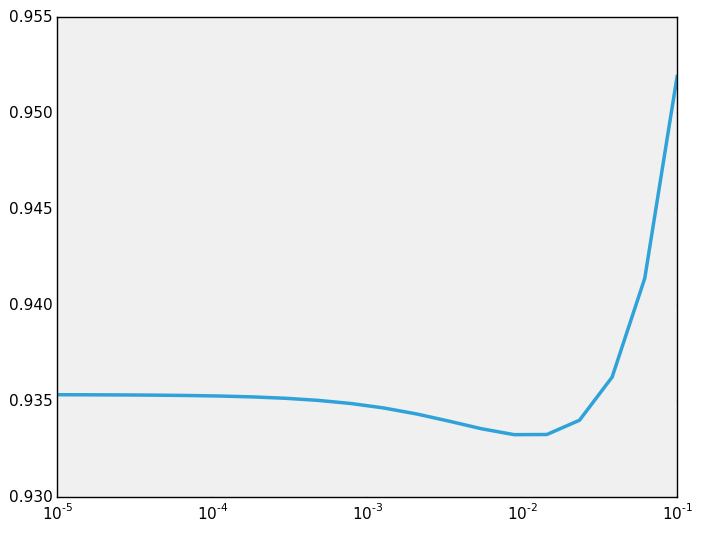

In [29]:
plt.semilogx(weights, results)

In [32]:
class_predictions.shape

(3089, 121)

Now process all vectors. Make a big list with predictions for each vector.

In [33]:
all_predictions = [[] for k in range(len(hier))]
start = 0

for i in range(len(hier)):
    end = len(hier[i])
    all_predictions[i] = predictions[:, start:(start + end)]
    start = start + end

Check the dimensions are right.

In [34]:
[z.shape for z in all_predictions]

[(3089, 121), (3089, 38), (3089, 16), (3089, 7), (3089, 4), (3089, 2)]

Make a list for priors for all vectors. Set it with class priors in the zeroth vector.

In [36]:
priors = [[] for k in range(len(hier))]

for i in range(len(hier)):
    priors[i] = np.zeros(len(hier[i])) 

priors[0] = settings.class_priors

In [37]:
priors

[array([ 0.02930512,  0.00042853,  0.00234045,  0.00161524,  0.00052743,
         0.01753692,  0.02294304,  0.00797732,  0.01295491,  0.0056039 ,
         0.02686577,  0.06375264,  0.02287711,  0.00253824,  0.02244858,
         0.0057028 ,  0.00316456,  0.00586762,  0.00207674,  0.00942774,
         0.0034942 ,  0.00161524,  0.00286788,  0.00098892,  0.02963476,
         0.03919436,  0.00079114,  0.00662579,  0.00372495,  0.00138449,
         0.0017471 ,  0.00125264,  0.00181303,  0.01196598,  0.01298787,
         0.03012922,  0.01710839,  0.01648207,  0.00118671,  0.0030327 ,
         0.00263713,  0.00290084,  0.01269119,  0.01766878,  0.00316456,
         0.00089003,  0.0004615 ,  0.00448312,  0.00125264,  0.01684467,
         0.00032964,  0.00102189,  0.00280195,  0.00375791,  0.0021097 ,
         0.00052743,  0.00032964,  0.00418645,  0.00247231,  0.00115374,
         0.00754879,  0.00029668,  0.00062632,  0.00075818,  0.00435127,
         0.01107595,  0.00039557,  0.00626319,  0.0

Propagate up to compute superclass group priors in all vectors.

In [38]:
# For each class
for index, h in enumerate(hier):
    if (index < 5):
        layer = t.TaxonomyLayer(index + 1)

        for i, c in enumerate(settings.classes):    
            # Find index of its parent in 1-of-k encodings
            j = int(np.where(np.array(hier[index + 1]) == layer[c])[0])

            # Add class's prior for that superclass group
            priors[index + 1][j] += settings.class_priors[i]

In [39]:
priors

[array([ 0.02930512,  0.00042853,  0.00234045,  0.00161524,  0.00052743,
         0.01753692,  0.02294304,  0.00797732,  0.01295491,  0.0056039 ,
         0.02686577,  0.06375264,  0.02287711,  0.00253824,  0.02244858,
         0.0057028 ,  0.00316456,  0.00586762,  0.00207674,  0.00942774,
         0.0034942 ,  0.00161524,  0.00286788,  0.00098892,  0.02963476,
         0.03919436,  0.00079114,  0.00662579,  0.00372495,  0.00138449,
         0.0017471 ,  0.00125264,  0.00181303,  0.01196598,  0.01298787,
         0.03012922,  0.01710839,  0.01648207,  0.00118671,  0.0030327 ,
         0.00263713,  0.00290084,  0.01269119,  0.01766878,  0.00316456,
         0.00089003,  0.0004615 ,  0.00448312,  0.00125264,  0.01684467,
         0.00032964,  0.00102189,  0.00280195,  0.00375791,  0.0021097 ,
         0.00052743,  0.00032964,  0.00418645,  0.00247231,  0.00115374,
         0.00754879,  0.00029668,  0.00062632,  0.00075818,  0.00435127,
         0.01107595,  0.00039557,  0.00626319,  0.0

Check they sum to 1.

In [40]:
[sum(q) for q in priors]

[0.99999999999999978, 0.99999999999999989, 1.0, 1.0, 1.0, 0.99999999999999978]

Make a big list for all new predictions.

In [41]:
new_predictions = [np.zeros(class_predictions.shape) for k in range(len(hier))]
new_predictions[0] = class_predictions

In [42]:
new_predictions

[array([[  9.99387145e-01,   6.10206451e-04,   4.26387174e-07, ...,
           5.54376206e-13,   1.65371735e-16,   3.49470248e-08],
        [  9.99947071e-01,   5.03214542e-05,   2.10997632e-06, ...,
           2.14432869e-13,   1.17589905e-16,   4.98193042e-09],
        [  9.91560280e-01,   8.43962282e-03,   4.58615190e-08, ...,
           2.34763855e-14,   1.16694699e-19,   6.70220546e-10],
        ..., 
        [  1.56537055e-07,   1.68523400e-07,   7.05214909e-09, ...,
           5.59777301e-03,   1.80633634e-03,   1.74993405e-03],
        [  1.91399234e-03,   6.32083276e-04,   1.26820625e-04, ...,
           6.61337897e-02,   1.59019802e-03,   2.37437367e-01],
        [  1.72780656e-05,   5.68424040e-12,   2.82246387e-04, ...,
           1.14716023e-07,   1.05788604e-04,   2.46290383e-05]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]

In [43]:
# For each array of new predictions
for pred in range(len(new_predictions)):
    # No need to update the zeroth one
    if pred > 0:
        layer = t.TaxonomyLayer(pred)
        # For each image
        for index, row in enumerate(new_predictions[pred]):
            # For each class
            for i, c in enumerate(settings.classes):
                # Find the parent
                j = int(np.where(np.array(hier[pred]) == layer[c])[0])
                new_predictions[pred][index, i] = all_predictions[pred][index, j] * (settings.class_priors[i] / priors[pred][j])

In [44]:
new_predictions

[array([[  9.99387145e-01,   6.10206451e-04,   4.26387174e-07, ...,
           5.54376206e-13,   1.65371735e-16,   3.49470248e-08],
        [  9.99947071e-01,   5.03214542e-05,   2.10997632e-06, ...,
           2.14432869e-13,   1.17589905e-16,   4.98193042e-09],
        [  9.91560280e-01,   8.43962282e-03,   4.58615190e-08, ...,
           2.34763855e-14,   1.16694699e-19,   6.70220546e-10],
        ..., 
        [  1.56537055e-07,   1.68523400e-07,   7.05214909e-09, ...,
           5.59777301e-03,   1.80633634e-03,   1.74993405e-03],
        [  1.91399234e-03,   6.32083276e-04,   1.26820625e-04, ...,
           6.61337897e-02,   1.59019802e-03,   2.37437367e-01],
        [  1.72780656e-05,   5.68424040e-12,   2.82246387e-04, ...,
           1.14716023e-07,   1.05788604e-04,   2.46290383e-05]]),
 array([[  9.13668193e-01,   1.33607272e-02,   7.29701257e-02, ...,
           1.53098840e-09,   8.45182872e-10,   2.05258697e-09],
        [  9.13668411e-01,   1.33607304e-02,   7.29701431e-0